In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
import datetime 
from datetime import date
from datetime import *; from dateutil.relativedelta import *
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.9f' % x)
np.set_printoptions(suppress=True)

In [53]:
import pydata_google_auth
credentials = pydata_google_auth.get_user_credentials(
    ['https://www.googleapis.com/auth/bigquery'],
)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=262006177488-3425ks60hkk80fssi9vpohv88g6q1iqd.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=V9wVqhg2CTlf06xsfIAgBd9aS5MCie&access_type=offline


In [54]:
client = bigquery.Client(project = 'etsy-bigquery-adhoc-prod', credentials=credentials)

In [73]:
# sql for `etsy-data-warehouse-dev.tnormil.affiliate_purchases_crosschannel` 
# sql = """
# with past_visitors as 
#     (select mapped_user_id, min(date(start_datetime)) as first_visit_date
#     #case when utm_content in ('57697','54760') then utm_content else '0' end as utm_content, case when utm_content in ('57697','54760') then publisher else 'affiliates' end as publisher, 
#     from `etsy-data-warehouse-prod.buyatt_mart.visits_vw` v 
#     join `etsy-data-warehouse-prod.user_mart.user_profile` up on v.user_id = up.user_id
#     join `etsy-data-warehouse-prod.static.affiliates_publisher_by_tactic` p on v.utm_content = p.PUBLISHER_ID
#     where marketing_region = 'GB'
#     and second_channel = 'affiliates'
#     #and utm_content in ('57697','54760')
#     and v._date >= date_sub(DATE '2022-04-01', INTERVAL 2 YEAR)
#     group by 1), 
# dates as 
#     (SELECT distinct date, mapped_user_id
#     FROM past_visitors s
#     join UNNEST(GENERATE_DATE_ARRAY(first_visit_date, DATE '2022-08-01', INTERVAL 1 DAY)) AS date),
# status as      
#     (SELECT distinct 
#     date,
#     pv.mapped_user_id, 
#     CASE
#         WHEN buyer_type = 'new_buyer' THEN 'new_buyer'
#         WHEN purchase_day_number = 2
#          AND buyer_type <> 'reactivated_buyer' THEN '2x_buyer'
#         WHEN purchase_day_number = 3
#          AND buyer_type <> 'reactivated_buyer' THEN '3x_buyer'
#         WHEN purchase_day_number >= 4 and purchase_day_number<= 9
#          AND buyer_type <> 'reactivated_buyer' THEN '4_to_9x_buyer'
#         WHEN purchase_day_number >= 10
#          AND buyer_type <> 'reactivated_buyer' THEN '10plus_buyer'
#         WHEN buyer_type = 'reactivated_buyer' THEN 'reactivated_buyer'
#         ELSE 'other'
#       END AS buyer_type, purchase_day_number, row_number() over (partition by pv.mapped_user_id order by purchase_date desc, purchase_day_number desc) as rank
#     FROM dates pv
#     left join `etsy-data-warehouse-prod.buyatt_mart.buyatt_analytics_clv` clv on pv.mapped_user_id = clv.mapped_user_id and date <= clv.purchase_date
#     qualify rank = 1
#     #buyer type status on given date before future purchases
#     ),
# receipts_historical_users as     
# (select d.date, d.buyer_type, 
# clv.receipt_id, sum(external_source_decay_all * gms) as attr_gms,
# #sum(case when d.utm_content = v.utm_content then external_source_decay_all * gms end) as attr_gms_same_cashback_partner,
# sum(case when second_channel = 'affiliates' then external_source_decay_all * gms end) attr_gms_affiliates,
# from status d
# left join `etsy-data-warehouse-prod.buyatt_mart.buyatt_analytics_clv` clv on d.mapped_user_id = clv.mapped_user_id and d.date = clv.purchase_date and clv.purchase_date >= '2022-01-01'
# left join `etsy-data-warehouse-prod.buyatt_mart.attr_by_browser` ab on clv.receipt_id = ab.receipt_id and date(ab.receipt_timestamp) >=  '2022-01-01'
# left join `etsy-data-warehouse-prod.buyatt_mart.visits_vw` v on ab.o_visit_id = v.visit_id and v._date >= '2021-11-01'
# group by 1,2,3)
# select date, buyer_type, 
# sum(attr_gms) as attr_gms,
# sum(attr_gms_affiliates) attr_gms_affiliates,
# from receipts_historical_users 
# group by 1, 2;
# """

sql = """
SELECT date as channel_overview_purchase_date_purchase_date_date, buyer_type, sum(attr_gms) as channel_overview_purchase_date_attributed_gms_mult_m
FROM `etsy-data-warehouse-dev.tnormil.affiliate_purchases_crosschannel` 
where date >= (DATE('2021-01-01')) 
group by 1,2
"""

query_job = client.query(sql)
results = query_job.result()
quidco_base = results.to_dataframe()

In [56]:




new_col = []

for i in quidco_base.columns:
    
    if i == 'channel_overview_purchase_date_purchase_date_date':
        
        new_col.append(i)
    
    else:
        
        new_col.append(i + '_quidco')

quidco_base.columns = new_col      

In [57]:
quidco_base.sort_values('channel_overview_purchase_date_purchase_date_date').isna().head()

,channel_overview_purchase_date_purchase_date_date,channel_overview_purchase_date_attributed_gms_mult_m_quidco
458,False,True
460,False,True
462,False,True
464,False,True
466,False,True


In [7]:
sql = """
WITH static_affiliates_publisher_by_tactic AS (select coalesce(a.publisher_id, b.publisher_id, c.publisher_id) as publisher_id,
    a.publisher,
    a.tactic,
    case when b.publisher_id is not null then True else False end as tiktok,
    b.is_seller,
    upper(b.program_joined) as program_joined,
    case when c.publisher_id is not null then True else False end as influencer_cc
    from `etsy-data-warehouse-prod.static.affiliates_publisher_by_tactic` a
    full outer join `etsy-data-warehouse-prod.static.affiliates_publisher_by_tactic_tiktok` b using (publisher_id)
    full outer join (select distinct publisher_id from `etsy-data-warehouse-prod.rollups.influencer_cc_overview`) c using (publisher_id))
SELECT
    (channel_overview_purchase_date.purchase_date ) AS channel_overview_purchase_date_purchase_date_date,
    COALESCE(SUM(( coalesce(channel_overview_purchase_date.attributed_gms_mult, 0)  ) ), 0) AS channel_overview_purchase_date_attributed_gms_mult_m,
    COALESCE(SUM(( coalesce(channel_overview_purchase_date.attributed_gms_mult_dly, 0)  ) ), 0) AS channel_overview_purchase_date_attributed_gms_mult_dly_m,
    COALESCE(SUM(( coalesce(channel_overview_purchase_date.attributed_gms_mult_dlly, 0)  ) ), 0) AS channel_overview_purchase_date_attributed_gms_mult_dlly_m,
    COALESCE(SUM(( coalesce(channel_overview_purchase_date.attributed_gms_mult_d3ly, 0)  ) ), 0) AS channel_overview_purchase_date_attributed_gms_mult_d3ly_m
FROM `etsy-data-warehouse-prod.buyatt_rollups.derived_channel_overview_restricted_purch_date`  AS channel_overview_purchase_date
LEFT JOIN static_affiliates_publisher_by_tactic ON channel_overview_purchase_date.utm_content = static_affiliates_publisher_by_tactic.publisher_id
WHERE (channel_overview_purchase_date.purchase_date ) >= (DATE('2021-01-01')) AND (channel_overview_purchase_date.marketing_region ) = 'GB' AND (initcap(channel_overview_purchase_date.second_channel)
      ) = 'Affiliates' AND ((channel_overview_purchase_date.utm_content ) <> '57697' AND (channel_overview_purchase_date.utm_content ) <> '54760' AND (channel_overview_purchase_date.utm_content ) <> '281763' AND (channel_overview_purchase_date.utm_content ) <> '97931' OR (channel_overview_purchase_date.utm_content ) IS NULL) AND (static_affiliates_publisher_by_tactic.tactic ) IN ('Cashback', 'Coupon', 'Loyalty', 'Loyalty Charity')
GROUP BY
    1
ORDER BY
    1 DESC;
"""

query_job = client.query(sql)
results = query_job.result()
affiliates_cashback_base = results.to_dataframe()

In [8]:
new_col = []

for i in affiliates_cashback_base.columns:
    
    if i == 'channel_overview_purchase_date_purchase_date_date':
        
        new_col.append(i)
    
    else:
        
        new_col.append(i + '_affiliates_cashback')

affiliates_cashback_base.columns = new_col 

In [9]:
affiliates_cashback_base.head()

,channel_overview_purchase_date_purchase_date_date,channel_overview_purchase_date_attributed_gms_mult_m_affiliates_cashback,channel_overview_purchase_date_attributed_gms_mult_dly_m_affiliates_cashback,channel_overview_purchase_date_attributed_gms_mult_dlly_m_affiliates_cashback,channel_overview_purchase_date_attributed_gms_mult_d3ly_m_affiliates_cashback
0,2022-10-03,6041.200900595,7106.183811953,8077.725890273,2503.823802883
1,2022-10-02,6921.953356105,7611.864973121,5846.907181008,2820.092455699
2,2022-10-01,4948.033729615,6884.608639847,5353.279509468,1859.536198821
3,2022-09-30,6653.016118679,7404.511412817,5199.411360765,2359.481943468
4,2022-09-29,5509.871609748,6380.482296591,4575.366002794,1963.086059600


In [10]:
sql = """
SELECT
    (channel_overview_purchase_date.purchase_date ) AS channel_overview_purchase_date_purchase_date_date,
    COALESCE(SUM(( coalesce(channel_overview_purchase_date.attributed_gms_mult, 0)  ) ), 0) AS channel_overview_purchase_date_attributed_gms_mult_m,
    COALESCE(SUM(( coalesce(channel_overview_purchase_date.attributed_gms_mult_dly, 0)  ) ), 0) AS channel_overview_purchase_date_attributed_gms_mult_dly_m,
    COALESCE(SUM(( coalesce(channel_overview_purchase_date.attributed_gms_mult_dlly, 0)  ) ), 0) AS channel_overview_purchase_date_attributed_gms_mult_dlly_m,
    COALESCE(SUM(( coalesce(channel_overview_purchase_date.attributed_gms_mult_d3ly, 0)  ) ), 0) AS channel_overview_purchase_date_attributed_gms_mult_d3ly_m
FROM `etsy-data-warehouse-prod.buyatt_rollups.derived_channel_overview_restricted_purch_date`  AS channel_overview_purchase_date
WHERE (channel_overview_purchase_date.purchase_date ) >= (DATE('2021-01-01')) AND (channel_overview_purchase_date.marketing_region ) = 'GB'
GROUP BY
    1
ORDER BY
    1 DESC
"""

query_job = client.query(sql)
results = query_job.result()
overall_base = results.to_dataframe()

In [11]:
new_col = []

for i in overall_base.columns:
    
    if i == 'channel_overview_purchase_date_purchase_date_date':
        
        new_col.append(i)
    
    else:
        
        new_col.append(i + '_overall')

overall_base.columns = new_col

In [12]:
overall_base.head()

,channel_overview_purchase_date_purchase_date_date,channel_overview_purchase_date_attributed_gms_mult_m_overall,channel_overview_purchase_date_attributed_gms_mult_dly_m_overall,channel_overview_purchase_date_attributed_gms_mult_dlly_m_overall,channel_overview_purchase_date_attributed_gms_mult_d3ly_m_overall
0,2022-10-03,2897125.390990041,3577854.808709004,2875258.225867383,849720.680565902
1,2022-10-02,3227177.323518098,4111350.142329444,3409553.911108792,882972.887804723
2,2022-10-01,2783814.032930129,3857274.099195264,3222037.730574595,756972.374177611
3,2022-09-30,2852653.984153986,3328402.520324685,2740572.577723593,747458.321775059
4,2022-09-29,2432743.251131354,3632757.043166976,2763780.800352637,739028.248146986


In [58]:
quidco_base['channel_overview_purchase_date_purchase_date_date'] = pd.to_datetime(quidco_base['channel_overview_purchase_date_purchase_date_date'])
affiliates_cashback_base['channel_overview_purchase_date_purchase_date_date'] = pd.to_datetime(affiliates_cashback_base['channel_overview_purchase_date_purchase_date_date'])
overall_base['channel_overview_purchase_date_purchase_date_date'] = pd.to_datetime(overall_base['channel_overview_purchase_date_purchase_date_date'])


In [59]:
quidco_base_new = quidco_base.set_index('channel_overview_purchase_date_purchase_date_date', drop=True)
affiliates_cashback_base_new = affiliates_cashback_base.set_index('channel_overview_purchase_date_purchase_date_date', drop=True)
overall_base_new = overall_base.set_index('channel_overview_purchase_date_purchase_date_date', drop=True)

In [63]:
model_base = pd.concat([quidco_base_new, affiliates_cashback_base_new, overall_base_new], axis=1, join='outer', ignore_index=False)

exclusion_dates = pd.date_range(start='01/01/2022', end=model_base.index.max(), freq='D')

model_base = model_base.loc[model_base.index.isin(exclusion_dates)]

model_base = model_base.fillna(0).astype(int)

model_base = model_base.sort_index()


In [64]:
model_base.head(150)

,channel_overview_purchase_date_attributed_gms_mult_m_quidco,channel_overview_purchase_date_attributed_gms_mult_m_affiliates_cashback,channel_overview_purchase_date_attributed_gms_mult_dly_m_affiliates_cashback,channel_overview_purchase_date_attributed_gms_mult_dlly_m_affiliates_cashback,channel_overview_purchase_date_attributed_gms_mult_d3ly_m_affiliates_cashback,channel_overview_purchase_date_attributed_gms_mult_m_overall,channel_overview_purchase_date_attributed_gms_mult_dly_m_overall,channel_overview_purchase_date_attributed_gms_mult_dlly_m_overall,channel_overview_purchase_date_attributed_gms_mult_d3ly_m_overall
channel_overview_purchase_date_purchase_date_date,,,,,,,,,
2022-01-01,11245,5929,7011,1823,2512,2960919,3749941,802066,554496
2022-01-02,14376,5662,6580,3422,2697,3786478,3757892,970167,632177
2022-01-03,13985,8129,5435,2327,2609,3874985,3431859,865255,617057
2022-01-04,15134,8488,4976,1785,2461,3554207,3383246,828331,564889
2022-01-05,14088,5619,5103,2094,3935,3450249,3418188,787295,545045
...,...,...,...,...,...,...,...,...,...
2022-05-26,9356,5016,4041,4431,1893,2911176,2773449,2172838,775580
2022-05-27,12640,6930,4235,3982,1980,2873522,3128383,2241690,774317
2022-05-28,16898,7096,5217,3699,1459,2772649,2768347,2034060,658623


In [65]:
from causalimpact import CausalImpact
import tensorflow as tf

In [66]:
pre_period = ['2022-01-01', '2022-03-31']
post_period = ['2022-04-01', '2022-06-08']
ci = CausalImpact(model_base, pre_period=pre_period, post_period=post_period)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: nseasons, standardize. After release 0.14, this will raise.
  warnings.warn(


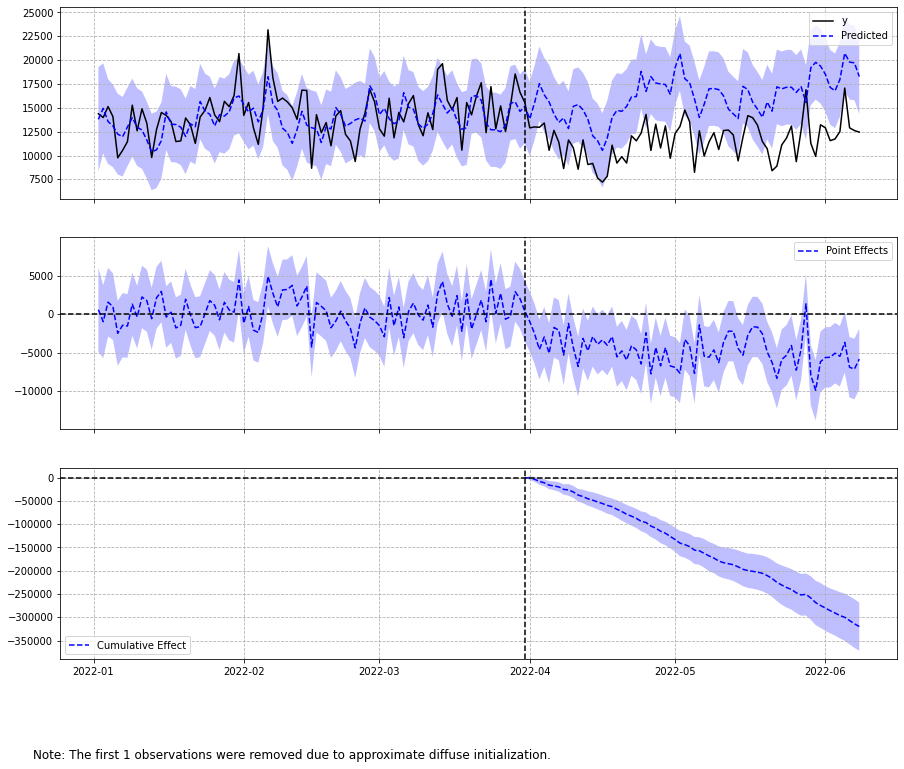

In [67]:
ci.plot()

In [68]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    11562.45           797809.0
Prediction (s.d.)         16196.86 (383.28)  1117583.05 (26446.27)
95% CI                    [15448.46, 16950.88][1065943.56, 1169611.02]

Absolute effect (s.d.)    -4634.41 (383.28)  -319774.05 (26446.27)
95% CI                    [-5388.44, -3886.01][-371802.02, -268134.56]

Relative effect (s.d.)    -28.61% (2.37%)    -28.61% (2.37%)
95% CI                    [-33.27%, -23.99%] [-33.27%, -23.99%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [69]:
print(ci.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 11562.45. By contrast, in the absence of an
intervention, we would have expected an average response of 16196.86.
The 95% interval of this counterfactual prediction is [15448.46, 16950.88].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -4634.41 with a 95% interval of
[-5388.44, -3886.01]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 797809.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 1117583.05. The 95% interval of this prediction is [1065943.56, 1169611.02].


The above results are given in terms of absolute numbers. In 

In [70]:
pre_period = ['2022-01-01', '2022-03-31']
post_period = ['2022-04-01', '2022-08-01']
ci = CausalImpact(model_base, pre_period=pre_period, post_period=post_period)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: nseasons, standardize. After release 0.14, this will raise.
  warnings.warn(


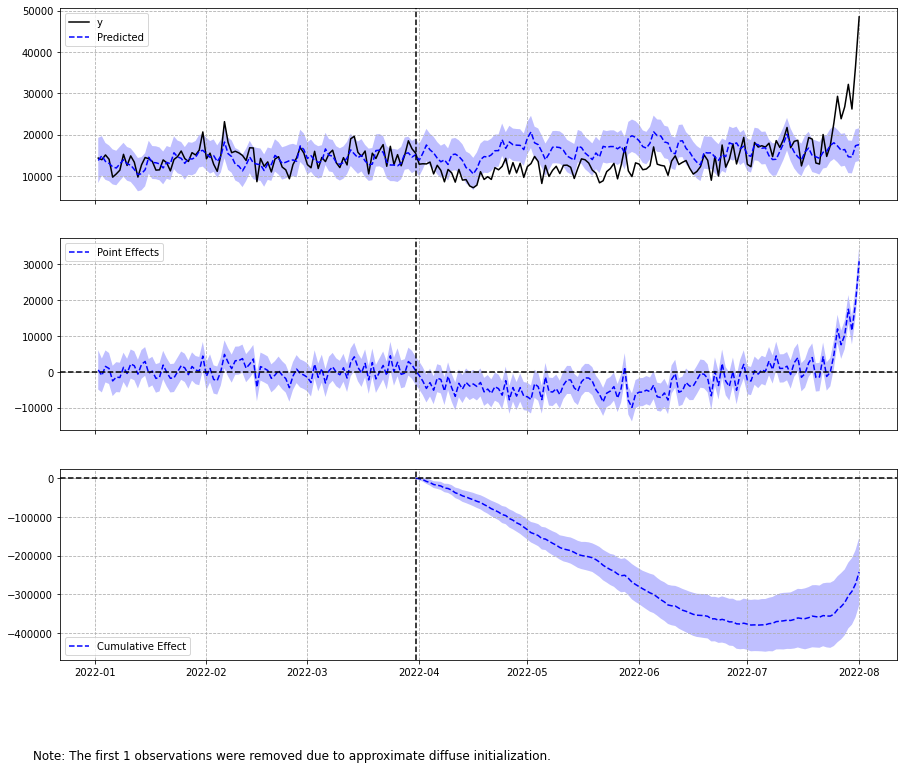

In [71]:
ci.plot()

In [72]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    14177.11           1743784.0
Prediction (s.d.)         16146.3 (361.1)    1985995.51 (44415.6)
95% CI                    [15433.19, 16848.69][1898282.64, 2072388.57]

Absolute effect (s.d.)    -1969.2 (361.1)    -242211.51 (44415.6)
95% CI                    [-2671.58, -1256.09][-328604.57, -154498.64]

Relative effect (s.d.)    -12.2% (2.24%)     -12.2% (2.24%)
95% CI                    [-16.55%, -7.78%]  [-16.55%, -7.78%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [52]:
print(ci.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 1121588.53. By contrast, in the absence of an
intervention, we would have expected an average response of 1180895.72.
The 95% interval of this counterfactual prediction is [1164662.47, 1197205.64].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -59307.19 with a 95% interval of
[-75617.11, -43073.94]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 137955389.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 145250173.57. The 95% interval of this prediction is [143253484.14, 147256293.19].


The above results are given in terms of a